In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os,sys                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow import keras


In [2]:
print(os.listdir("train"))

['Cancer', 'Normal']


In [3]:

TRAIN_DIR = "train"
TEST_DIR =  "test"

In [59]:
#Preprocessing 
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if nextdir in ['NORMAL']:
            label = 0
        elif nextdir in ['CANCER']:
            label = 1
        else:
            label = 2
    return nextdir, label

In [5]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [6]:
 #X_train, y_train = preprocessing_data(TRAIN_DIR)

In [7]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if nextDir in ['NORMAL']:
            label = 0
        elif nextDir in ['CANCER']:
            label = 1
        else:
            label = 2
                
            temp = Dir + '/' + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [8]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████████████████████████████████████████████████████████████████████████| 2483/2483 [02:08<00:00, 19.33it/s]


In [9]:
X_test , y_test = get_data(TEST_DIR)

100%|████████████████████████████████████████████████████████████████████████████████| 620/620 [00:16<00:00, 37.39it/s]


In [10]:
print(X_train.shape,'\n',X_test.shape)

(4961, 150, 150, 3) 
 (1249, 150, 150, 3)


In [11]:
print(y_train.shape,'\n',y_test.shape)

(4961,) 
 (1249,)


In [12]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



Using TensorFlow backend.


In [13]:
print(y_train.shape,'\n',y_test.shape)

(4961, 3) 
 (1249, 3)


In [14]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

In [52]:
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [53]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [54]:
#X_train=X_train.reshape(5216,3,150,150)
#X_test=X_test.reshape(624,3,150,150)

In [55]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(150,150,3)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 150, 150, 32)      4640      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 150, 150, 64)      18496     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 64)       

In [60]:
batch_size = 256
epochs = 40

In [58]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)


In [25]:
model.save('leukemia-model.h5')

In [61]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)


In [63]:
from matplotlib import pyplot as plt
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()


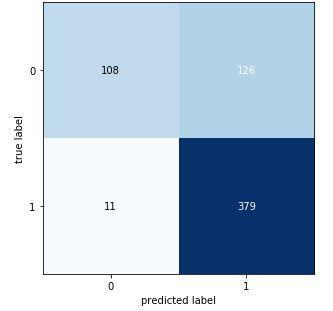

In [29]:
#PRECISION = (TP/(TP+FP))
379/(379+126)

0.7504950495049505

In [30]:
#RECALL = (TP/(TP+FN))
379 / (379 + 11)

0.9717948717948718

In [33]:
#ACCURACY = (TP+TN)/(TP+TN+FP+FN)
(379+108)/(379+108+126+11)

0.780448717948718